In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
# tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# model
import tensorflow as tf
import keras
from keras import backend as K
# from keras.layers import Embedding
from keras.models import Model
from keras import layers
from keras import Input
from keras import optimizers
from tensorflow.keras import regularizers
# data split and result analysis
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Read data

In [2]:
path = '../input/prepared-datasets/'
train_set = pd.read_csv(path+'train_set.csv')
val_set = pd.read_csv(path+'val_set.csv')
test_set = pd.read_csv(path+'test_set.csv')

# Create tokenizer

In [3]:
train_amazon_info = train_set["amazon_info"].tolist()
train_google_info = train_set["google_info"].tolist()
val_amazon_info = val_set["amazon_info"].tolist()
val_google_info = val_set["google_info"].tolist()
# Combine all text data
all_data_text = train_amazon_info + train_google_info + val_amazon_info + val_google_info

# Retrieve all the tokens in the dataset
def create_tokenizer(all_text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_text)
    word_index = tokenizer.word_index
    print("Found %s unique tokens"%len(word_index))
    return tokenizer, word_index

# Create tokenizer according to all the words in train data
tokenizer, data_word_index = create_tokenizer(all_data_text)

Found 15332 unique tokens


# Word Embedding

In [4]:
embedding_matrix = np.load('../input/word-embedding/embedding_matrix_word2vec.npy')
max_words = len(data_word_index)
embedding_dim = 300

## Model Auxiliary function

In [5]:
# Calculate the cosine similarity
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

# Custom F1 score, recall and precision 
class customMetrics(tf.keras.callbacks.Callback):
    def __init__(self, validation):   
        super(customMetrics, self).__init__()
        self.validation = validation    
            
#         print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.f1_scores = []
        self.recalls = []
        self.precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        true_labels = self.validation[1]   
        predictions = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        f1_score_epoch = f1_score(true_labels, predictions)
        recall_epoch = recall_score(true_labels, predictions)         
        precision_epoch = precision_score(true_labels, predictions)
        
        self.f1_scores.append(round(f1_score_epoch, 6))
        self.recalls.append(round(recall_epoch, 6))
        self.precisions.append(round(precision_epoch, 6))
 
        print("\nRecall: ",recall_epoch,"   Precision: ",precision_epoch, "   f1: ",f1_score_epoch)


In [ ]:
tf.keras.backend.clear_session

In [ ]:
# from keras.utils import plot_model

# maxlen = 200

# model = model_average()

# plot_model(model, to_file='model.png',show_shapes=True,show_layer_names=False)

In [6]:
def plot_loss_acc(history):
    '''
    Plot train val loss and acc
    '''
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    axes[0].plot(history.history['loss'], label='loss')
    axes[0].plot(history.history['val_loss'], label='val_loss')
    axes[1].plot(history.history['acc'], label='acc')
    axes[1].plot(history.history['val_acc'], label='val_acc')

    for ax in axes:
        ax.legend()
        ax.grid(True)
        ax.set(xlabel='epoch')
        
def sigmoid_prob(model, X_test):
    '''
    Return probabilities for positive class calculated by sigmoid output layer
    Take trained model and val or test data as Input
    '''
    prob_y = model.predict(X_test, verbose=0) 
    return prob_y        

def label_pred(prob_y, threshold):
    '''
    Return the labels predicted by sigmoid output lalyer under certain threshold
    Take sigmoid output probability and threshold as Input
    '''
    pred_y = np.where(prob_y > threshold, 1, 0)
    return pred_y
 
def c_matrix(model, X_test, y_test, threshold):
    '''
    Output confusion matrix
    Take trained model, test data, test label and threshold as Input
    '''
    prob_y = model.predict(X_test, verbose=0) 
    pred_y = np.where(prob_y > threshold, 1, 0)
    cm = confusion_matrix(y_test, pred_y)
    print(cm)

def area_under_curve(model, X_test, y_test):
    '''
    Output AUC - Area Under Curve
    Take trained model, test data and test label as Input
    '''
    y_probs = sigmoid_prob(model, X_test)
    nn_precision, nn_recall, threds = precision_recall_curve(y_test, y_probs)   
    nn_auc = auc(nn_recall, nn_precision)
    return nn_auc, nn_recall, nn_precision

def pr_curve(model, X_test, y_test):
    '''
    PR curve and Area Under Curve
    Take trained model, test data and test labels as Input
    '''
    nn_auc, nn_recall, nn_precision = area_under_curve(model, X_test, y_test)
    print("The AUC is ",nn_auc)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    fig, axes = plt.subplots(1, 1, figsize=(6,6))
    axes.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    axes.plot(nn_recall, nn_precision, marker='.', label='DNN')
    # axis labels
    axes.set(xlabel='Recall')
    axes.set(ylabel='Precision')
    # show the legend
    axes.legend()
    
def plot_f1_recall_precision(custom_metrics):
    '''
    Plot the f1 score, recall and precision
    Take custome_metrics as Input
    '''
    val_f1 = custom_metrics.f1_scores
    val_recall = custom_metrics.recalls
    val_precision = custom_metrics.precisions
    epochs = range(1,len(val_f1)+1)
    plt.figure()
    plt.plot(epochs, val_f1, 'red', label="validation f1 score")
    plt.plot(epochs, val_recall, 'yellow', label="validation recall")
    plt.plot(epochs, val_precision, 'green', label="validation precision")
    plt.legend()
    plt.show()
    return plt    

def result_statistics(custom_metrics, model, X_test, y_test, history):
    """
    Return the max_f1, max_recall, max_precision, auc, train_loss and val_loss
    """ 
    val_f1 = np.asarray(custom_metrics.f1_scores)
    val_recall = np.asarray(custom_metrics.recalls)
    val_precision = np.asarray(custom_metrics.precisions)
    # get the max recall
    max_recall = max(val_recall)
    index_max_recall = np.squeeze(np.where(val_recall == max(val_recall))).tolist() # may more than one
    # get the max precision under max recall
    if isinstance(index_max_recall,list): # True if there are more than one index
        max_precision = max(val_precision[index_max_recall])
        index_max_precision = np.squeeze(np.where(val_precision == max_precision)).tolist()
        if isinstance(index_max_precision, list): 
            index_max_precision = index_max_precision[0]
    else:
        max_precision = val_precision[index_max_recall]
        index_max_precision = index_max_recall

    # get the corresponding f1 score
    cor_f1 = val_f1[index_max_precision]
    
    nn_auc = area_under_curve(model, X_test, y_test)[0]
    
    min_loss = min(history.history["loss"])
    min_val_loss = min(history.history["val_loss"])
    
    res_stats = [max_recall, max_precision, cor_f1, nn_auc, min_loss, min_val_loss]
    return res_stats

# Resamping positives in Train set

In [ ]:
sns.countplot(x='label',data=train_set,palette='hls')
plt.savefig("original_class_ratio.png")
plt.show()

In [7]:
negative_index = np.squeeze(np.where(train_set["label"] == 0))
print("No. of negatives : ",len(negative_index))
negative_samples = train_set.iloc[negative_index.tolist(),:]

positive_index = np.squeeze(np.where(train_set["label"] == 1))
print("No. of positives : ",len(positive_index))
positive_samples = train_set.iloc[positive_index.tolist(),:]
positive_samples = positive_samples.append([positive_samples]*56, ignore_index=True)
print("No. of positives after resampling: ",len(positive_samples))

No. of negatives :  48114
No. of positives :  844
No. of positives after resampling:  48108


In [8]:
data_samples = positive_samples.append([negative_samples],ignore_index = True)
data_samples = data_samples.sample(frac=1)
data_samples.head(2)

,similarity,label,amazon_name,google_name,amazon_description,google_description,amazon_info,google_info,price_diff,price_nan_indicator
14935,0.33,1,adobe audition,adobe audition win retail ue u,adobe audition gives professional audio mixing...,audition win retail ue u,adobe audition adobe audition gives profession...,adobe audition win retail ue u audition win re...,0.151289,0
5538,0.56,1,learn play chess fritz chesster mac,viva media llc learn play chess fritz chesster,learn play chess fritz chesster lets king day ...,jump chess action move move rescue chesster de...,learn play chess fritz chesster mac learn play...,viva media llc learn play chess fritz chesster...,0.128376,0


In [ ]:
sns.countplot(x='label',data=data_samples,palette='hls')
plt.savefig("resampling_class_ratio.png")
plt.show()

In [ ]:
sns.countplot(x='label',data=val_set,palette='hls')
plt.savefig("resampling_class_ratio.png")
plt.show()

# Tokenization

In [9]:
maxlen = 200

def extract_features(data):
    '''
    Output the feature lists that will be used to train model
    Take the dataset as Input
    '''
    amazon_name = data["amazon_name"].tolist()
    google_name = data["google_name"].tolist()
    amazon_desc = data["amazon_description"].tolist()
    google_desc = data["google_description"].tolist()
    price_diff = np.asarray(data["price_diff"])
    price_indicator = np.asarray(data["price_nan_indicator"])
    
    return amazon_name, google_name, amazon_desc, google_desc, price_diff, price_indicator

def tokenization (tokenizer, text, maxlen):
    '''
    Output the integer lists which meet the input requirement of Model
    Take the tokenizer, text and considered max length as Input
    '''
    #convert to integer lists
    sequences = tokenizer.texts_to_sequences(text)
    # padding
    sequences = pad_sequences(sequences, maxlen)
    return sequences

## Extract & Tokenize attributes

In [10]:
# Train set
train_amazon_name, train_google_name, train_amazon_desc, train_google_desc, train_price_diff, train_price_indicator = extract_features(data_samples)

# convert the text into integer list
train_amazon_name_seq = tokenization(tokenizer, train_amazon_name, maxlen)
train_google_name_seq = tokenization(tokenizer, train_google_name, maxlen)
train_amazon_desc_seq = tokenization(tokenizer, train_amazon_desc, maxlen)
train_google_desc_seq = tokenization(tokenizer, train_google_desc, maxlen)

train_data = [train_amazon_name_seq, train_google_name_seq, train_amazon_desc_seq, train_google_desc_seq, train_price_diff, train_price_indicator]
train_labels = np.asarray(data_samples['label'])


# Val set
val_amazon_name, val_google_name, val_amazon_desc, val_google_desc, val_price_diff, val_price_indicator = extract_features(val_set)

# convert the text into integer list
val_amazon_name_seq = tokenization(tokenizer, val_amazon_name, maxlen)
val_google_name_seq = tokenization(tokenizer, val_google_name, maxlen)
val_amazon_desc_seq = tokenization(tokenizer, val_amazon_desc, maxlen)
val_google_desc_seq = tokenization(tokenizer, val_google_desc, maxlen)

val_data = [val_amazon_name_seq, val_google_name_seq, val_amazon_desc_seq, val_google_desc_seq, val_price_diff, val_price_indicator]
val_labels = np.asarray(val_set['label'])


# Test set
test_amazon_name, test_google_name, test_amazon_desc, test_google_desc, test_price_diff, test_price_indicator = extract_features(test_set)

test_amazon_name_seq = tokenization(tokenizer, test_amazon_name, maxlen)
test_google_name_seq = tokenization(tokenizer, test_google_name, maxlen)
test_amazon_desc_seq = tokenization(tokenizer, test_amazon_desc, maxlen)
test_google_desc_seq = tokenization(tokenizer, test_google_desc, maxlen)

test_data = [test_amazon_name_seq, test_google_name_seq, test_amazon_desc_seq, test_google_desc_seq, test_price_diff, test_price_indicator]
test_labels = np.asarray(test_set["label"])

print("Train: ",len(train_labels))
print("Val: ",len(val_labels))
print("Test: ", len(test_labels))

Train:  96222
Val:  12240
Test:  3487


# Average Model

, bias_regularizer=regularizers.l2(0.001)

In [22]:
def model_average():
    amazon_name = Input(shape=(maxlen, ))
    google_name = Input(shape=(maxlen, ))
    amazon_desc = Input(shape=(maxlen, ))
    google_desc = Input(shape=(maxlen, ))
    price_diff = Input(shape=(1,))
    price_indicator = Input(shape=(1,))

    # Embedding layer
    embedding_layer = layers.Embedding(max_words+1, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False)
    embedded_amazon_name = embedding_layer(amazon_name)
    embedded_amazon_desc = embedding_layer(amazon_desc)
    embedded_google_name = embedding_layer(google_name)
    embedded_google_desc = embedding_layer(google_desc)

    # Custom Average Layer
    average_amazon_name = layers.Lambda(lambda x: K.mean(x, axis=1))(embedded_amazon_name)
    average_amazon_desc = layers.Lambda(lambda x: K.mean(x, axis=1))(embedded_amazon_desc)
    average_google_name = layers.Lambda(lambda x: K.mean(x, axis=1))(embedded_google_name)
    average_google_desc = layers.Lambda(lambda x: K.mean(x, axis=1))(embedded_google_desc)

    # Cosine Similarity layer
    name_cossim = layers.Lambda(cosine_distance, output_shape=cos_dist_output_shape)([average_amazon_name,average_google_name])
    desc_cossim = layers.Lambda(cosine_distance, output_shape=cos_dist_output_shape)([average_amazon_desc,average_google_desc])

    concatenated = layers.concatenate([name_cossim, desc_cossim, price_diff, price_indicator],axis=-1)

    dense_1 = layers.Dense(32, activation='relu', bias_regularizer=regularizers.l2(0.001))(concatenated)
    dense_2 = layers.Dense(16, activation='relu', bias_regularizer=regularizers.l2(0.001))(dense_1)
    dense_3 = layers.Dense(8, activation='relu', bias_regularizer=regularizers.l2(0.001))(dense_2)

    out = layers.Dense(1, activation='sigmoid')(dense_3)

    model = Model([amazon_name, google_name, amazon_desc, google_desc, price_diff, price_indicator], out)
#     model.summary()
    return model

In [23]:
model_ave = model_average()
model_ave.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=optimizers.Adam(0.00001))
custom_metric = customMetrics(validation=(val_data, val_labels))
history_ave = model_ave.fit(train_data, train_labels,
                 epochs = 20, batch_size = 128,
                 validation_data=(val_data, val_labels),
                 callbacks=[custom_metric], verbose=1)

Epoch 1/20
751/752 [============================>.] - ETA: 0s - loss: 0.6935 - acc: 0.5028
Recall:  0.9054726368159204    Precision:  0.02137153593236261    f1:  0.04175748537340828
752/752 [==============================] - 21s 28ms/step - loss: 0.6935 - acc: 0.5028 - val_loss: 0.6950 - val_acc: 0.3176
Epoch 2/20
750/752 [============================>.] - ETA: 0s - loss: 0.6872 - acc: 0.7483
Recall:  0.8905472636815921    Precision:  0.03767627867817302    f1:  0.07229402261712439
752/752 [==============================] - 20s 27ms/step - loss: 0.6872 - acc: 0.7482 - val_loss: 0.6951 - val_acc: 0.6247
Epoch 3/20
751/752 [============================>.] - ETA: 0s - loss: 0.6808 - acc: 0.7425
Recall:  0.8905472636815921    Precision:  0.036545528787260105    f1:  0.07020984506766033
752/752 [==============================] - 20s 26ms/step - loss: 0.6808 - acc: 0.7425 - val_loss: 0.6991 - val_acc: 0.6127
Epoch 4/20
751/752 [============================>.] - ETA: 0s - loss: 0.6736 - acc: 

In [25]:
model_ave.save('model_average.h5')

In [15]:
result_statistics(custom_metric, model_ave, val_data, val_labels, history_ave)

[0.950249,
 0.033532,
 0.064779,
 0.1290906149364346,
 0.4849565327167511,
 0.5540996193885803]

In [30]:
c_matrix(model_ave, val_data, val_labels, threshold=0.5)

[[9072 2967]
 [  36  165]]


The AUC is  0.14190461632439189


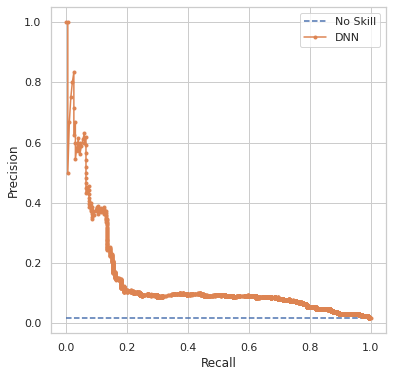

In [31]:
pr_curve(model_ave, val_data, val_labels)

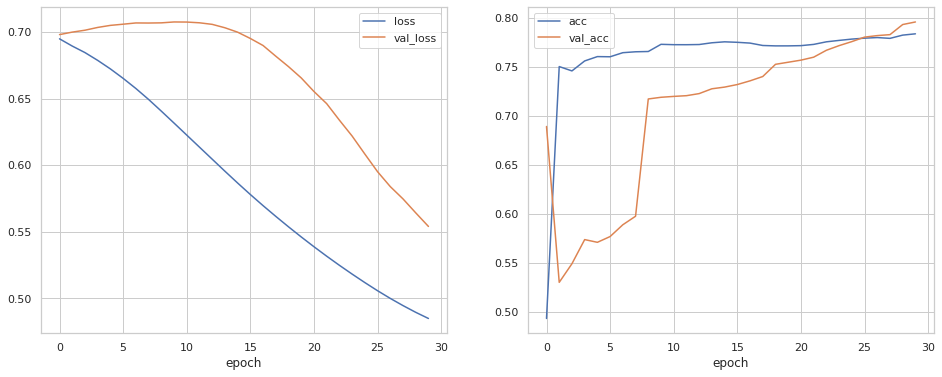

In [18]:
plot_loss_acc(history_ave)

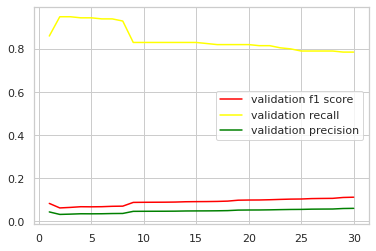

In [19]:
a = plot_f1_recall_precision(custom_metric)

In [13]:
def model_lstm():
    amazon_name = Input(shape=(maxlen, ))
    google_name = Input(shape=(maxlen, ))
    amazon_desc = Input(shape=(maxlen, ))
    google_desc = Input(shape=(maxlen, ))
    price_diff = Input(shape=(1,))
    price_indicator = Input(shape=(1,))

    # Embedding layer
    embedding_layer = layers.Embedding(max_words+1, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False)
    embedded_amazon_name = embedding_layer(amazon_name)
    embedded_amazon_desc = embedding_layer(amazon_desc)
    embedded_google_name = embedding_layer(google_name)
    embedded_google_desc = embedding_layer(google_desc)

     # Shared LSTM Layer
    shared_lstm = layers.LSTM(150)
    lstm_amazon_name = shared_lstm(embedded_amazon_name)
    lstm_amazon_desc = shared_lstm(embedded_amazon_desc)
    lstm_google_name = shared_lstm(embedded_google_name)
    lstm_google_desc = shared_lstm(embedded_google_desc)

    # Cosine Similarity layer
    name_diff = layers.Subtract()([lstm_amazon_name,lstm_google_name])
    desc_diff = layers.Subtract()([lstm_amazon_desc,lstm_google_desc])

    concatenated = layers.concatenate([name_diff, desc_diff, price_diff, price_indicator],axis=-1)

    dense_1 = layers.Dense(32, activation='relu', bias_regularizer=regularizers.l2(0.001))(concatenated)
    dense_2 = layers.Dense(16, activation='relu', bias_regularizer=regularizers.l2(0.001))(dense_1)
    dense_3 = layers.Dense(8, activation='relu', bias_regularizer=regularizers.l2(0.001))(dense_2)

    out = layers.Dense(1, activation='sigmoid')(dense_1)

    model = Model([amazon_name, google_name, amazon_desc, google_desc, price_diff, price_indicator], out)
    model.summary()
    return model

In [26]:
model_lst = model_lstm()
model_lst.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=optimizers.Adam(0.0001))
train_data = [train_amazon_name_seq, train_google_name_seq, train_amazon_desc_seq, train_google_desc_seq, train_price_diff, train_price_indicator]
val_data = [val_amazon_name_seq, val_google_name_seq, val_amazon_desc_seq, val_google_desc_seq, val_price_diff, val_price_indicator]
custom_metric_lst = customMetrics(validation=(val_data, val_labels))
history_lst = model_lst.fit(train_data, train_labels,
                 epochs = 20, batch_size = 128,
                 validation_data=(val_data, val_labels),
                 callbacks=[custom_metric_lst], verbose=1)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 200)]        0                                            
_______________________________________________________________________________________

752/752 [==============================] - ETA: 0s - loss: 0.0242 - acc: 0.9947
Recall:  0.19900497512437812    Precision:  0.14492753623188406    f1:  0.16771488469601678
752/752 [==============================] - 89s 119ms/step - loss: 0.0242 - acc: 0.9947 - val_loss: 0.2042 - val_acc: 0.9676
Epoch 15/20
752/752 [==============================] - ETA: 0s - loss: 0.0210 - acc: 0.9954
Recall:  0.19402985074626866    Precision:  0.14181818181818182    f1:  0.16386554621848737
752/752 [==============================] - 89s 119ms/step - loss: 0.0210 - acc: 0.9954 - val_loss: 0.2082 - val_acc: 0.9675
Epoch 16/20
752/752 [==============================] - ETA: 0s - loss: 0.0189 - acc: 0.9957
Recall:  0.18407960199004975    Precision:  0.14624505928853754    f1:  0.16299559471365638
752/752 [==============================] - 89s 119ms/step - loss: 0.0189 - acc: 0.9957 - val_loss: 0.2191 - val_acc: 0.9690
Epoch 17/20
752/752 [==============================] - ETA: 0s - loss: 0.0168 - acc: 0.9

In [27]:
model_lst.save("model_LSTM.h5")

In [28]:
c_matrix(model_lst, val_data, val_labels, threshold=0.5)

[[11857   182]
 [  164    37]]


The AUC is  0.08614244480518413


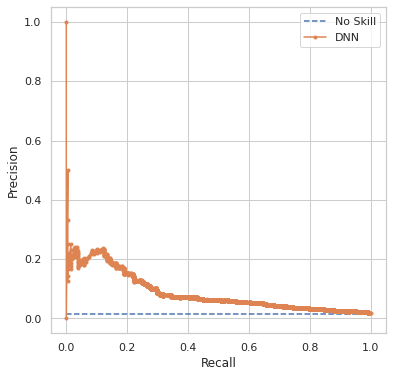

In [29]:
pr_curve(model_lst, val_data, val_labels)